In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games = pd.read_csv("./data/game.csv")
ratings = pd.read_csv("./data/review.csv")

In [3]:
n_ratings = len(ratings)
n_games = ratings["game_id"].nunique()
n_users = ratings["user_id"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique games: {n_games}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per game: {round(n_ratings/n_games, 2)}")

Number of ratings: 42565
Number of unique games: 100
Number of unique users: 41337
Average number of ratings per user: 1.03
Average number of ratings per game: 425.65


### Game ratings distribution

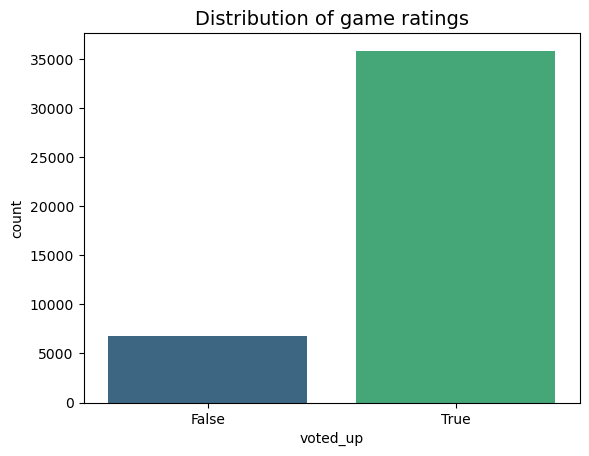

In [4]:
sns.countplot(x="voted_up", data=ratings, palette="viridis")
plt.title("Distribution of game ratings", fontsize=14)
plt.show()

In [5]:
print(f"Mean global rating: {round(ratings["voted_up"].mean(),2)}.")

mean_ratings = ratings.groupby("user_id")["voted_up"].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 0.84.
Mean rating per user: 0.84.


### Most rated games

In [6]:
game_ratings = ratings.merge(games, on="game_id")
game_ratings["title"].value_counts()[0:10]

title
Last Epoch               7293
Palworld                 2625
Supermarket Simulator    1853
Rust                     1303
Enshrouded               1175
Terraria                 1039
Wallpaper Engine          988
Stardew Valley            987
Project Zomboid           799
Garry's Mod               766
Name: count, dtype: int64

## Lowest, highest rated

By mean vote

In [7]:
mean_ratings = ratings.groupby("game_id")[["voted_up"]].mean()
lowest_rated = mean_ratings["voted_up"].idxmin()
games[games["game_id"] == lowest_rated]

,game_id,title,released,price,overall,positive%,reviews,tags
78,1158160,Coral Island,"14 Nov, 2023","385.000,00₫",Very Positive,0.88,12508,"Farming Sim, Life Sim, Relaxing, Simulation, D..."


In [8]:
highest_rated = mean_ratings["voted_up"].idxmax()
games[games["game_id"] == highest_rated]

,game_id,title,released,price,overall,positive%,reviews,tags
96,233860,Kenshi,"6 Dec, 2018","250.000,00₫",Overwhelmingly Positive,0.95,68108,"Open World, Sandbox, RPG, Survival, Strategy, ..."


By up vote percentage

In [9]:
games[games["positive%"]==games["positive%"].min()]

,game_id,title,released,price,overall,positive%,reviews,tags
51,513710,SCUM,"29 Aug, 2018","565.000,00₫",Mostly Positive,0.75,80764,"Survival, Open World Survival Craft, Multiplay..."


In [10]:
games[games["positive%"]==games["positive%"].max()]

,game_id,title,released,price,overall,positive%,reviews,tags
6,413150,Stardew Valley,"26 Feb, 2016","165.000,00₫",Overwhelmingly Positive,0.98,558601,"Farming Sim, Life Sim, Pixel Graphics, Multipl..."
9,294100,RimWorld,"17 Oct, 2018","350.000,00₫",Overwhelmingly Positive,0.98,151940,"Colony Sim, Base Building, Survival, Strategy,..."
16,431960,Wallpaper Engine,Nov 2018,"70.000,00₫",Overwhelmingly Positive,0.98,701671,"Mature, Utilities, Software, Anime, Design & I..."
23,1145360,Hades,"17 Sep, 2020","321.000,00₫",Overwhelmingly Positive,0.98,227668,"Action Roguelike, Roguelite, Hack and Slash, I..."
71,1794680,Vampire Survivors,"20 Oct, 2022","70.000,00₫",Overwhelmingly Positive,0.98,215034,"Action Roguelike, Bullet Hell, Pixel Graphics,..."
85,2231450,Pizza Tower,"26 Jan, 2023","188.000,00₫",Overwhelmingly Positive,0.98,48866,"Great Soundtrack, 2D Platformer, Fast-Paced, C..."


#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [11]:
game_stats = ratings.groupby("game_id")["voted_up"].agg(["count", "mean"])
game_stats.head(100)

,count,mean
game_id,,
4000,766,0.945170
16900,143,0.762238
105600,1039,0.953802
108600,799,0.942428
221100,585,0.815385
...,...,...
2273430,562,0.967972
2427700,658,0.924012
2497920,430,0.920930


In [12]:
C = game_stats["count"].mean()
m = game_stats["mean"].mean()

print(f"Average number of ratings for a given game: {C:.2f}")
print(f"Average rating for a given game: {m:.2f}")


def bayesian_avg(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given game: 425.65
Average rating for a given game: 0.87


In [13]:
bayesian_avg_ratings = (
    ratings.groupby("game_id")["voted_up"].agg(bayesian_avg).reset_index()
)
bayesian_avg_ratings.columns = ["game_id", "bayesian_avg"]
game_stats = game_stats.merge(bayesian_avg_ratings, on="game_id")
game_stats

,game_id,count,mean,bayesian_avg
0,4000,766,0.945170,0.920
1,16900,143,0.762238,0.845
2,105600,1039,0.953802,0.930
3,108600,799,0.942428,0.918
4,221100,585,0.815385,0.840
...,...,...,...,...
95,2273430,562,0.967972,0.927
96,2427700,658,0.924012,0.904
97,2497920,430,0.920930,0.897
98,2555190,409,0.970660,0.921


In [14]:
game_stats = game_stats.merge(games[["game_id", "title"]])
game_stats.sort_values(by="bayesian_avg", ascending=False)

,game_id,count,mean,bayesian_avg,title
25,413150,987,0.978723,0.947,Stardew Valley
27,431960,988,0.971660,0.942,Wallpaper Engine
2,105600,1039,0.953802,0.930,Terraria
12,264710,438,0.984018,0.929,Subnautica
7,242760,465,0.976344,0.927,The Forest
...,...,...,...,...,...
30,513710,205,0.502439,0.753,SCUM
61,1158160,187,0.459893,0.747,Coral Island
16,291550,374,0.593583,0.742,Brawlhalla
39,671860,412,0.563107,0.721,BattleBit Remastered


### Game tags

In [15]:
games["tags"] = games["tags"].apply(lambda x: x.split(", "))

In [16]:
from collections import Counter

tags_frequency = Counter(tag for tags in games["tags"] for tag in tags)

print(f"There are {len(tags_frequency)} tags.")

tags_frequency

There are 287 tags.


Counter({'Indie': 99,
         'Singleplayer': 85,
         'Action': 63,
         'Multiplayer': 59,
         'Adventure': 52,
         'Simulation': 48,
         'Open World': 44,
         'Sandbox': 42,
         'Co-op': 40,
         'First-Person': 38,
         'Survival': 35,
         'Atmospheric': 32,
         'RPG': 31,
         '2D': 30,
         'Early Access': 29,
         'Exploration': 27,
         'Building': 26,
         'Casual': 26,
         'Crafting': 25,
         'Online Co-Op': 25,
         'Strategy': 23,
         'Difficult': 22,
         'Realistic': 20,
         'Story Rich': 20,
         'Funny': 20,
         '3D': 19,
         'Pixel Graphics': 18,
         'Horror': 18,
         'Base Building': 17,
         'Great Soundtrack': 17,
         'Management': 16,
         'Roguelike': 16,
         'Open World Survival Craft': 15,
         'Replay Value': 14,
         'Roguelite': 14,
         'FPS': 13,
         'Moddable': 13,
         'Sci-fi': 13,
         'Ac

In [17]:
tags_frequency_df = pd.DataFrame([tags_frequency]).T.reset_index()
tags_frequency_df.columns = ["tag", "count"]
tags_frequency_df

,tag,count
0,Multiplayer,59
1,Open World,44
2,Survival,35
3,Creature Collector,1
4,Open World Survival Craft,15
...,...,...
282,Dark Humor,1
283,Ninja,1
284,Alternate History,1
285,Steampunk,1


In [18]:
print("The 5 most common tags: \n", tags_frequency.most_common(5))

The 5 most common tags: 
 [('Indie', 99), ('Singleplayer', 85), ('Action', 63), ('Multiplayer', 59), ('Adventure', 52)]


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

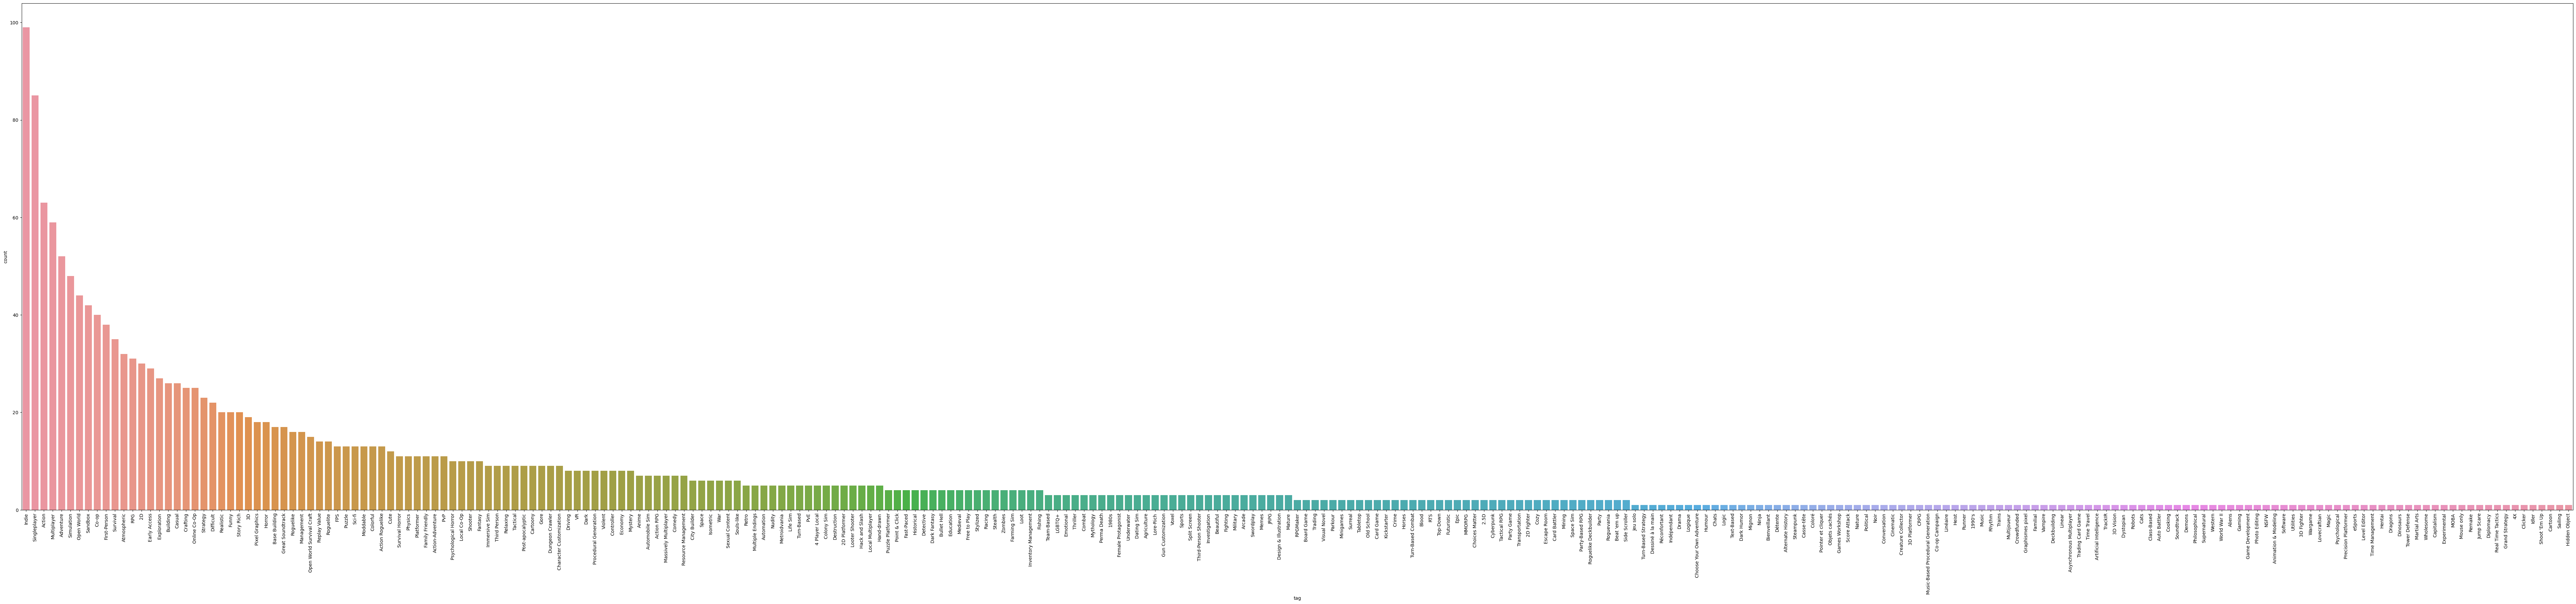

In [19]:
plt.figure(figsize=(100, 20))
sns.barplot(
    x="tag",
    y="count",
    data=tags_frequency_df.sort_values(by="count", ascending=False),
)
plt.xticks(rotation=90)

### Data preprocessing

In [20]:
from scipy.sparse import csr_matrix


def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (game_id, game_id, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        game_mapper: dict that maps game id's to game indices
        game_inv_mapper: dict that maps game indices to game id's
    """
    M = df["user_id"].nunique()
    N = df["game_id"].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    game_mapper = dict(zip(np.unique(df["game_id"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    game_inv_mapper = dict(zip(list(range(N)), np.unique(df["game_id"])))

    user_index = [user_mapper[i] for i in df["user_id"]]
    item_index = [game_mapper[i] for i in df["game_id"]]

    X = csr_matrix((df["voted_up"], (user_index, item_index)), shape=(M, N))

    return X, user_mapper, game_mapper, user_inv_mapper, game_inv_mapper


X, user_mapper, game_mapper, user_inv_mapper, game_inv_mapper = create_X(ratings)

In [21]:
X.shape

(41337, 100)

Sparsity

In [22]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.03%


In [23]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

41337

In [24]:
print(f"Most active user rated {n_ratings_per_user.max()} game.")
print(f"Least active user rated {n_ratings_per_user.min()} games.")

Most active user rated 10 game.
Least active user rated 1 games.


In [25]:
n_ratings_per_game = X.getnnz(axis=0)
len(n_ratings_per_game)

100

In [26]:
print(f"Most rated game has {n_ratings_per_game.max()} ratings.")
print(f"Least rated game has {n_ratings_per_game.min()} ratings.")

Most rated game has 7293 ratings.
Least rated game has 29 ratings.


c:\Users\Admin\anaconda3\envs\walapy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Admin\anaconda3\envs\walapy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


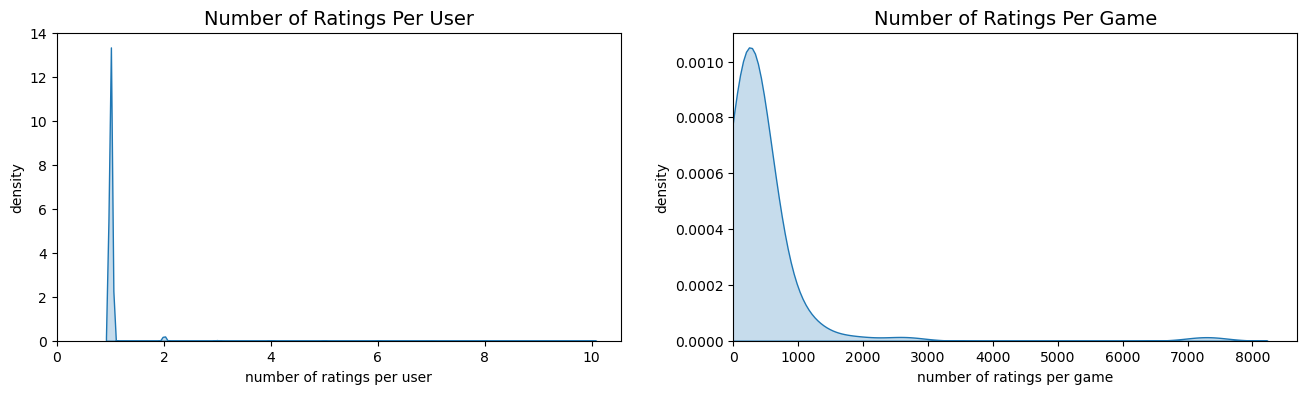

In [27]:
pd.option_context("mode.use_inf_as_na", True)
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_game, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Game", fontsize=14)
plt.xlabel("number of ratings per game")
plt.ylabel("density")
plt.show()

In [28]:
from sklearn.neighbors import NearestNeighbors


def find_similar_games(
    game_id, X, game_mapper, game_inv_mapper, k, metric="cosine"
):
    """
    Finds k-nearest neighbours for a given game id.

    Args:
        game_id: id of the game of interest
        X: user-item utility matrix
        k: number of similar games to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar game ID's
    """
    X = X.T
    neighbour_ids = []

    game_ind = game_mapper[game_id]
    game_vec = X[game_ind]
    if isinstance(game_vec, (np.ndarray)):
        game_vec = game_vec.reshape(1, -1)
    # use k+1 since kNN output includes the gameId of interest
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(game_vec, return_distance=False)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(game_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [53]:
game_titles = dict(zip(games["game_id"], games["title"]))

game_id = 1623730

similar_games = find_similar_games(
    game_id, X, game_mapper, game_inv_mapper, metric="cosine", k=10
)
game_title = game_titles[game_id]

print(f"Because you played {game_title}:")
for i in similar_games:
    print(game_titles[i])

Because you played Palworld:
Enshrouded
Wallpaper Engine
Don't Starve Together
Slay the Spire
Subnautica
House Flipper 2
Medieval Dynasty
Terraria
A Way Out


### Handling cold start

In [30]:
n_games = games["game_id"].nunique()
print(f"There are {n_games} unique games in our games dataset.")

There are 100 unique games in our games dataset.


In [31]:
tags = set(t for tags in games["tags"] for t in tags)

for t in tags:
    games[t] = games.tags.transform(lambda x: int(t in x))

game_tags = games.drop(
    columns=[
        "released",
        "price",
        "overall",
        "positive%",
        "reviews", "game_id",
        "title",
        "tags",
    ]
)
game_tags.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_44012\991783859.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  games[t] = games.tags.transform(lambda x: int(t in x))
C:\Users\Admin\AppData\Local\Temp\ipykernel_44012\991783859.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  games[t] = games.tags.transform(lambda x: int(t in x))
C:\Users\Admin\AppData\Local\Temp\ipykernel_44012\991783859.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

,Auto Battler,Point & Click,Casse-tête,Shoot 'Em Up,Immersive Sim,Pointer et cliquer,Fishing,Coloré,Music-Based Procedural Generation,Fantasy,...,Psychological,Class-Based,Card Battler,Nature,Comedy,Online Co-Op,Realistic,Hand-drawn,Party Game,Level Editor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(game_tags, game_tags)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (100, 100)


In [33]:
cosine_sim[0]

array([1.        , 0.6       , 0.25      , 0.4       , 0.55      ,
       0.55      , 0.3       , 0.15      , 0.2       , 0.2       ,
       0.25      , 0.55      , 0.55      , 0.2       , 0.15      ,
       0.45      , 0.25      , 0.5       , 0.45      , 0.15      ,
       0.15      , 0.3       , 0.35      , 0.2       , 0.2       ,
       0.5       , 0.45      , 0.4       , 0.2       , 0.15      ,
       0.55      , 0.65      , 0.25      , 0.2       , 0.2       ,
       0.2       , 0.25      , 0.3       , 0.25      , 0.2       ,
       0.4       , 0.25      , 0.25      , 0.2       , 0.25      ,
       0.1       , 0.4       , 0.2       , 0.25      , 0.45      ,
       0.25      , 0.5       , 0.15      , 0.4       , 0.2       ,
       0.6       , 0.2       , 0.25      , 0.2       , 0.25      ,
       0.15389675, 0.3       , 0.        , 0.09128709, 0.4       ,
       0.2       , 0.2       , 0.25      , 0.15      , 0.4       ,
       0.2       , 0.15      , 0.25      , 0.25      , 0.35   

### Game finder

In [34]:
from fuzzywuzzy import process

def game_finder(title):
    all_titles = games['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [35]:
title = game_finder("pal")
title

'Palworld'

In [36]:
game_idx = dict(zip(games["title"], list(games.index)))
idx = game_idx[title]
print(f"Game index for Palworld: {idx}")

Game index for Palworld: 0


In [37]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1 : n_recommendations + 1]
sim_scores

[(31, 0.65),
 (1, 0.6),
 (55, 0.6),
 (4, 0.5499999999999999),
 (5, 0.5499999999999999),
 (11, 0.5499999999999999),
 (12, 0.5499999999999999),
 (30, 0.5499999999999999),
 (82, 0.5499999999999999),
 (17, 0.49999999999999994)]

In [38]:
similar_games = [x[0] for x in sim_scores]
print(f"Because you played {title}:")
games["title"].iloc[similar_games]

Because you watched Palworld:


31                  Valheim
1                Enshrouded
55    ARK: Survival Evolved
4                      Rust
5           Project Zomboid
11                 Terraria
12                     Raft
30             Satisfactory
82          Space Engineers
17               Subnautica
Name: title, dtype: object

In [42]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = game_finder(title_string)
    idx = game_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1 : (n_recommendations + 1)]
    similar_games = [i[0] for i in sim_scores]
    print(f"Because you played {title}:")
    print(games["title"].iloc[similar_games])

In [43]:
get_content_based_recommendations("pal", 5)

Because you played Palworld:
31                  Valheim
1                Enshrouded
55    ARK: Survival Evolved
4                      Rust
5           Project Zomboid
Name: title, dtype: object


### Dimensionality Reduction with Matrix Factorization (advanced)

In [51]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=12)
Q = svd.fit_transform(X.T)

game_id = 1623730  # Palworld
similar_games = find_similar_games(
    game_id, Q.T, game_mapper, game_inv_mapper, metric="euclidean", k=10
)
game_title = game_titles[game_id]

print(f"Because you played {game_title}:")
for i in similar_games:
    print(game_titles[i])

Because you played Palworld:
Slay the Spire
Don't Starve Together
Hell Let Loose
A Way Out
Bloons TD 6
Medieval Dynasty
House Flipper 2
ARK: Survival Evolved
DAVE THE DIVER
